# Project Description

In this project, we will train two models, UNet and FCN8s, to predict semantic segmentation. The dataset that we are going to use here is the dataset from Indonesia AI, which is obtained from the cityscapes dataset. This dataset contains images of a car's surroundings, including semantic segmentation. This project aims to compare the results of the two models and conclude which is the best for this study case.

# Libraries Import

We start this project by importing the required libraries first.

In [1]:
import gdown
import zipfile
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from tqdm import tqdm
import torchvision.models as models

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import torch.nn.functional as F

import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


We also delete the folder data in case if we want to restart and rerun this notebook so that the data are not duplicated.

In [2]:
!rm -rf data

# Data Collection

We download the data from the google drive.

In [3]:
!mkdir data/
!mkdir data/saved_model/

url1 = "https://drive.google.com/uc?id=1GwExwixckvu5sEZTMUkcyEtsRD9Dk8N3"
url2 = "https://drive.google.com/uc?id=14vlTnRa3no-ZNxA_tSNsePLjdDZ3JEQ9"
url3 = "https://drive.google.com/uc?id=1QwbNCh9NXMkyEX8PtJCGUJuXWbgqXqnh"
url4 = "https://drive.google.com/uc?id=1tnJdNTvMFBOJp7OxW2vuM0SPPhlp2B4S"

gdown.download(url1)
gdown.download(url2)
gdown.download(url3)
gdown.download(url4)

Downloading...
From: https://drive.google.com/uc?id=1GwExwixckvu5sEZTMUkcyEtsRD9Dk8N3
To: /content/annotations_prepped_train-20241111T025913Z-001.zip
100%|██████████| 2.30M/2.30M [00:00<00:00, 122MB/s]
Downloading...
From: https://drive.google.com/uc?id=14vlTnRa3no-ZNxA_tSNsePLjdDZ3JEQ9
To: /content/annotations_prepped_test-20241111T025903Z-001.zip
100%|██████████| 566k/566k [00:00<00:00, 95.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1QwbNCh9NXMkyEX8PtJCGUJuXWbgqXqnh
From (redirected): https://drive.google.com/uc?id=1QwbNCh9NXMkyEX8PtJCGUJuXWbgqXqnh&confirm=t&uuid=b85f7610-2b75-4a6d-a7c7-64c9f03e69c3
To: /content/images_prepped_test-20241111T025016Z-001.zip
100%|██████████| 28.6M/28.6M [00:00<00:00, 69.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1tnJdNTvMFBOJp7OxW2vuM0SPPhlp2B4S
From (redirected): https://drive.google.com/uc?id=1tnJdNTvMFBOJp7OxW2vuM0SPPhlp2B4S&confirm=t&uuid=56e1e754-b7b6-4171-a399-d5348966754d
To: /content/images_p

'images_prepped_train-20241111T024959Z-001.zip'

Then, we move it to the folder data and extract the zip file there.

In [4]:
!mv annotations_prepped_train-20241111T025913Z-001.zip /content/data
!mv annotations_prepped_test-20241111T025903Z-001.zip /content/data
!mv images_prepped_test-20241111T025016Z-001.zip /content/data
!mv images_prepped_train-20241111T024959Z-001.zip /content/data

In [5]:
!unzip data/annotations_prepped_train-20241111T025913Z-001.zip -d /content/data
!unzip data/annotations_prepped_test-20241111T025903Z-001.zip -d /content/data
!unzip data/images_prepped_test-20241111T025016Z-001.zip -d /content/data
!unzip data/images_prepped_train-20241111T024959Z-001.zip -d /content/data

Archive:  data/annotations_prepped_train-20241111T025913Z-001.zip
  inflating: /content/data/annotations_prepped_train/0006R0_f03210.png  
  inflating: /content/data/annotations_prepped_train/0001TP_007230.png  
  inflating: /content/data/annotations_prepped_train/0016E5_07320.png  
  inflating: /content/data/annotations_prepped_train/0016E5_07290.png  
  inflating: /content/data/annotations_prepped_train/0016E5_02220.png  
  inflating: /content/data/annotations_prepped_train/0006R0_f02550.png  
  inflating: /content/data/annotations_prepped_train/0016E5_06930.png  
  inflating: /content/data/annotations_prepped_train/0016E5_07680.png  
  inflating: /content/data/annotations_prepped_train/0006R0_f01140.png  
  inflating: /content/data/annotations_prepped_train/0016E5_01440.png  
  inflating: /content/data/annotations_prepped_train/0016E5_05820.png  
  inflating: /content/data/annotations_prepped_train/0016E5_08430.png  
  inflating: /content/data/annotations_prepped_train/0001TP_007080

# Data Cleaning

Let us check the files in the train dataset.

In [6]:
PATH = "/content/data/images_prepped_train"
files_list = os.listdir(PATH)
print(files_list)

['0016E5_06870.png', '0001TP_008340.png', '0001TP_007560.png', '0006R0_f02940.png', '0016E5_01080.png', '0016E5_06360.png', '0006R0_f03210.png', '0006R0_f01860.png', '0006R0_f03330.png', '0006R0_f01110.png', '0006R0_f03420.png', '0006R0_f03510.png', '0001TP_007890.png', '0006R0_f03690.png', '0016E5_02040.png', '0006R0_f01320.png', '0016E5_01830.png', '0016E5_06240.png', '0016E5_01350.png', '0006R0_f02310.png', '0016E5_06540.png', '0016E5_06120.png', '0006R0_f03270.png', '0006R0_f01680.png', '0006R0_f02010.png', '0006R0_f02550.png', '0016E5_07860(2).png', '0001TP_007050.png', '0006R0_f01710.png', '0016E5_00750.png', '0016E5_07860.png', '0001TP_006720.png', '0016E5_04470.png', '0016E5_00390.png', '0016E5_04950.png', '0006R0_f01800.png', '0016E5_06420.png', '0016E5_07860(1).png', '0001TP_007770.png', '0006R0_f01890.png', '0001TP_007800.png', '0006R0_f03720.png', '0016E5_01920.png', '0016E5_06600.png', '0016E5_06210.png', '0006R0_f02700.png', '0016E5_02310.png', '0016E5_05160.png', '0016E5

We can see that there are some files that are duplicated which can be identified from the file name. The duplicated file contains (1) or (2) in its file name. Hence, we will delete those duplicated files.

In [7]:
PATH = "/content/data/images_prepped_train"
files_list = os.listdir(PATH)

for file_name in files_list:
    if "(" in file_name and ")" in file_name:
        file_path = os.path.join(PATH, file_name)
        os.remove(file_path)
        print(f'Deleted: {file_name}')

Deleted: 0016E5_07860(2).png
Deleted: 0016E5_07860(1).png
Deleted: 0016E5_07920(2).png
Deleted: 0016E5_07740(2).png
Deleted: 0006R0_f03840(1).png
Deleted: 0016E5_07920(1).png
Deleted: 0016E5_07650(1).png
Deleted: 0016E5_07680(2).png
Deleted: 0016E5_07830(1).png
Deleted: 0006R0_f03810(1).png
Deleted: 0016E5_07680(1).png
Deleted: 0016E5_07770(1).png
Deleted: 0016E5_07800(2).png
Deleted: 0006R0_f03930(1).png
Deleted: 0016E5_07770(2).png
Deleted: 0006R0_f03780(1).png
Deleted: 0006R0_f03690(1).png
Deleted: 0016E5_05400(1).png
Deleted: 0016E5_07710(2).png
Deleted: 0006R0_f03600(1).png
Deleted: 0006R0_f03660(1).png
Deleted: 0016E5_07710(1).png
Deleted: 0016E5_07620(2).png
Deleted: 0006R0_f03720(1).png
Deleted: 0006R0_f03630(1).png
Deleted: 0016E5_07650(2).png
Deleted: 0016E5_07620(1).png
Deleted: 0006R0_f03750(1).png
Deleted: 0016E5_07800(1).png
Deleted: 0016E5_07830(2).png
Deleted: 0016E5_07740(1).png


In [8]:
PATH = "/content/data/images_prepped_test"
files_list = os.listdir(PATH)

for file_name in files_list:
    if "(" in file_name and ")" in file_name:
        file_path = os.path.join(PATH, file_name)
        os.remove(file_path)
        print(f'Deleted: {file_name}')

In [9]:
PATH = "/content/data/annotations_prepped_train"
files_list = os.listdir(PATH)

for file_name in files_list:
    if "(" in file_name and ")" in file_name:
        file_path = os.path.join(PATH, file_name)
        os.remove(file_path)
        print(f'Deleted: {file_name}')

In [10]:
PATH = "/content/data/annotations_prepped_test"
files_list = os.listdir(PATH)

for file_name in files_list:
    if "(" in file_name and ")" in file_name:
        file_path = os.path.join(PATH, file_name)
        os.remove(file_path)
        print(f'Deleted: {file_name}')

# Data Exploration

We will check the number of the data in the test dataset and train dataset.

In [11]:
PATH = "/content/data/images_prepped_train"
files_list = os.listdir(PATH)
print(f'The number of train dataset is {len(files_list)}')

PATH = "/content/data/images_prepped_test"
files_list = os.listdir(PATH)
print(f'The number of test dataset is {len(files_list)}')

The number of train dataset is 367
The number of test dataset is 101


Now we want to check one of the annotation image.

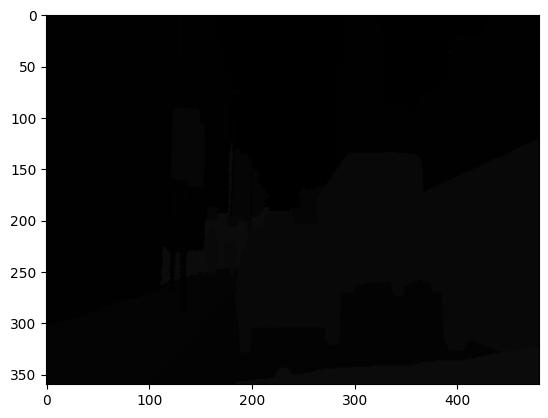

In [12]:
mask = cv2.imread("/content/data/annotations_prepped_train/0001TP_006690.png")
plt.imshow(mask)
plt.show()

We can see that the image is just black. However, actually, there are some annotations in this image. We can visualize it using the grayscale.

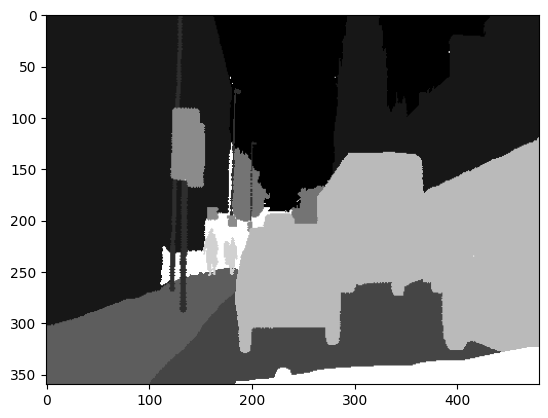

In [13]:
mask = cv2.imread("/content/data/annotations_prepped_train/0001TP_006690.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap='gray')
plt.show()

# Data Preprocessing

We will apply a transformation for the images. In this transformation we simply use resize and normalization.

In [14]:
data_transforms = A.Compose([
    A.Resize(256,256),
    A.Normalize(),
    ToTensorV2()
])

Let us explore the result of the transformation.

In [15]:
PATH = "/content/data/images_prepped_train"
files_list = os.listdir(PATH)
file_name = os.path.join(PATH, files_list[0])

image = Image.open(file_name).convert('RGB')
image_ori = np.array(image)

mask_ori = os.path.join("/content/data/annotations_prepped_train", files_list[0])

mask = Image.open(mask_ori).convert('L')
mask = np.asarray(mask)

unique_classes = np.unique(mask)

output = data_transforms(image=image_ori, mask=mask)
image = output['image']
mask = output['mask']

image = image.cpu().numpy()
image = np.transpose(image, (1, 2, 0))
image = (image + 1) * 127.5
image = np.clip(image, 0, 255).astype('uint8')

We will visualize a sample of the image and its transformation.

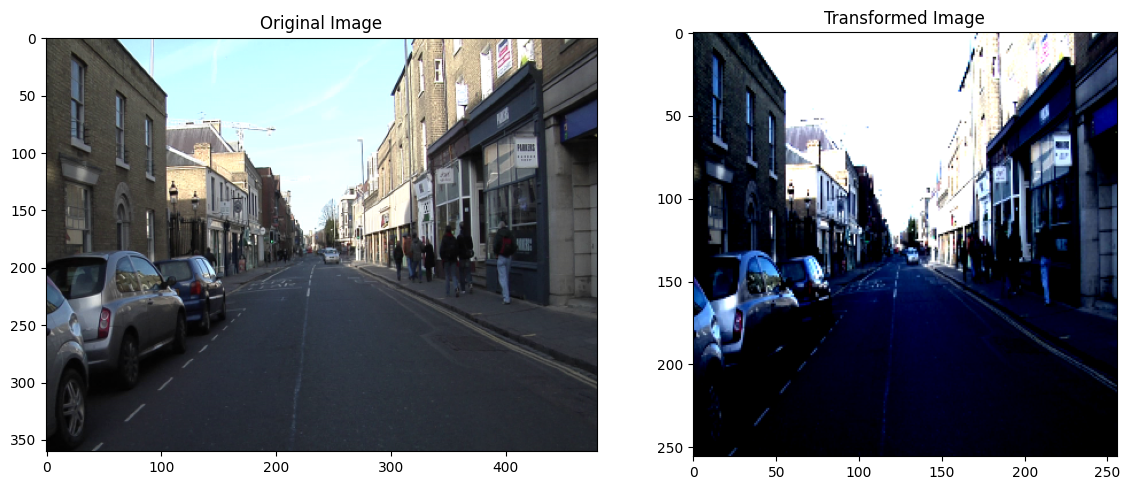

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_ori)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title('Transformed Image')

plt.tight_layout()
plt.show()

Next, we will visualize the annotation image.

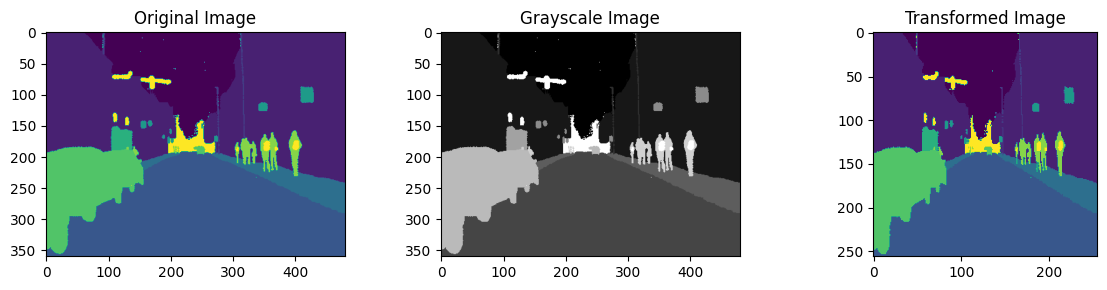

In [17]:
mask_ori = cv2.imread(mask_ori, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.imshow(mask_ori)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(mask_ori, cmap='gray')
plt.title('Grayscale Image')

plt.subplot(1, 3, 3)
plt.imshow(mask)
plt.title('Transformed Image')

plt.tight_layout()
plt.show()

# Dataset Class

Next, we will create the Cityscape dataset class. First, we check the number of classes exist in this dataset.

In [18]:
max_class_fix = 0
PATH = "/content/data/annotations_prepped_train"
files_list = os.listdir(PATH)

for i in range(len(files_list)):
  mask_ori = os.path.join(PATH, files_list[i])
  mask = Image.open(mask_ori)
  mask = np.array(mask)
  unique_classes = np.unique(mask)
  max_class = np.max(unique_classes)
  if max_class > max_class_fix:
    max_class_fix = max_class

print(f'The number of classes is: {max_class_fix+1}')

The number of classes is: 12


There are 12 classes in this dataset including the background. Then, we will create the Cityscapes dataset. We will encode all of the classes by using to_categorical from keras.

In [19]:
class Cityscapes(Dataset):
    def __init__(self, files_list, img_path, ann_path, num_classes=12):
        super().__init__()
        self.files_list = files_list
        self.img_path = img_path
        self.ann_path = ann_path
        self.num_classes = num_classes

    def __len__(self):
        return len(self.files_list)

    def __getitem__(self, idx):
        file_img = os.path.join(self.img_path, self.files_list[idx])
        mask_file = os.path.join(self.ann_path, self.files_list[idx])

        # Load the image and convert to RGB
        image = Image.open(file_img).convert('RGB')
        image = np.asarray(image)

        # Load the mask and convert to a numpy array
        mask = Image.open(mask_file).convert('L')
        mask = np.asarray(mask)

        # Apply the transformation
        output = data_transforms(image=image, mask=mask)
        image = output['image']
        mask = output['mask']

        # One-hot encode the mask
        mask = to_categorical(mask, num_classes=self.num_classes)

        # Change shape to [num_classes, height, width]
        mask = mask.transpose(2, 0, 1)

        return image, torch.tensor(mask, dtype=torch.float32)

# Train Val Test Split and Data Loader

We will split the test dataset into 80% train and 20% validation.

In [20]:
PATH = "/content/data/images_prepped_train"
files = os.listdir(PATH)
split = 0.8

for i in range(10):
  np.random.shuffle(files)

train_files = files[:int(len(files)*split)]
val_files = files[int(len(files)*split):]

Then, we create both dataset as follows.

In [21]:
img_path = "/content/data/images_prepped_train"
ann_path = "/content/data/annotations_prepped_train"

train_datasets = Cityscapes(train_files, img_path, ann_path)
val_datasets = Cityscapes(val_files, img_path, ann_path)

Next, we create the both dataloaders.

In [22]:
train_dataloader = DataLoader(train_datasets, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_datasets, batch_size=32, shuffle=True, num_workers=2)

Similarly, we create the test datasets and test dataloader.

In [23]:
img_path = "/content/data/images_prepped_test"
ann_path = "/content/data/annotations_prepped_test"

test_files = os.listdir(img_path)
test_datasets = Cityscapes(test_files, img_path, ann_path)
test_dataloader = DataLoader(test_datasets, batch_size=32, shuffle=False, num_workers=2)

# Model Construction

## UNet

Nex, we construct the UNet model as follows.

In [24]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # dobleconv, dobleconv..
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        #upsam, doubleconv, up, ..
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(#0
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))#1

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reversed(skip_connections)

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

We will use the cuda as the device so that it can perform faster. We set the in_channels of the UNet model to 3 as we have converted the image to RGB in the Cityscapes dataset class. We set the out_channels to 12 since we have 12 classes in this case. Lastly, we use adam optimizer for the model with learning rate 0.0001 or 1e-4.

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

unet = UNET(in_channels=3, out_channels=12)
unet.to(device)
optim_unet = torch.optim.Adam(unet.parameters(), lr = 1e-4)

## FCN8s

Now, we will create the FCN8s model.

In [26]:
class FCN8s(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s, self).__init__()
        vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        self.features = vgg16.features

        self.conv6 = nn.Conv2d(512, 4096, kernel_size=7)
        self.conv7 = nn.Conv2d(4096, 4096, kernel_size=1)
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)

        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4)

    def forward(self, x):
        pool3, pool4 = None, None

        # Extract features from VGG16
        for i, layer in enumerate(self.features):
            x = layer(x)
            if i == 16:  # After pool3
                pool3 = x
            elif i == 23:  # After pool4
                pool4 = x

        x = F.relu(self.conv6(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.conv7(x))
        x = F.dropout(x, p=0.5)

        x = self.score_fr(x)
        x = self.upscore2(x)

        # Align dimensions and add skip connections
        score_pool4 = self.score_pool4(pool4)
        score_pool4 = F.interpolate(score_pool4, size=x.shape[2:], mode="bilinear", align_corners=False)
        x = x + score_pool4
        x = self.upscore_pool4(x)

        score_pool3 = self.score_pool3(pool3)
        score_pool3 = F.interpolate(score_pool3, size=x.shape[2:], mode="bilinear", align_corners=False)
        x = x + score_pool3

        # Upsample to match the original image size
        x = self.upscore8(x)

        # Adjust to match y_true size which is 256 x 256
        x = F.interpolate(x, size=(256, 256), mode="bilinear", align_corners=False)
        return x

Likewise, we set the num_classes to 12 for this model and apply the same optimizer with the same learning rate.

In [27]:
fcn = FCN8s(num_classes=12)
fcn.to(device)
optim_fcn = torch.optim.Adam(fcn.parameters(), lr = 1e-4)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 162MB/s]


# Model Training

## Some Tools

We create the train_engine function to train the model for each epoch and calculate its loss value. In this function, we also apply Gradscaler to accelerate the training process. Subsequently, we construct the val_engine function to obtain the loss value of the model over the validation dataset.

In [28]:
scaler = torch.amp.GradScaler(device='cuda')

def train_engine(dataloader, model, loss_fn, optim, scaler=scaler):
    model.train()
    loss_one_step = 0
    loop = tqdm(dataloader)
    for data, targets in loop:
        data = data.to('cuda')
        targets = targets.float().to(device="cuda")
        # forward
        with torch.amp.autocast('cuda'):
            predictions = model(data)
            loss = loss_fn(targets, predictions)

        optim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        loss_one_step += loss.item()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

    return loss_one_step / len(dataloader)

def val_engine(dataloader, model, loss_fn):
    model.eval()
    loss_one_step = 0
    loop = tqdm(dataloader)

    for data, targets in loop:
        data = data.to('cuda')
        targets = targets.float().to(device="cuda")
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                predictions = model(data)
                loss = loss_fn(targets, predictions)
        loss_one_step += loss.item()

        loop.set_postfix(loss=loss.item())

    return loss_one_step / len(dataloader)

Both function above, then, are implemented to the train function which is the whole training process. In this function, we also save the training losses and validation losses for further analysis. The function will return the best model where the validation loss is the smallest during the training process and save both the best model and last model once the save_model parameter is set to True.

In [29]:
def train(train_dataloaders, val_dataloaders, model, loss_fn, optim, num_epochs, log_freq=10, save_model=False, best_model_name='best_model.pth', last_model_name='last_model.pth'):
    """
    Train the model for a given number of epochs.
    :param train_dataloaders: A dictionary of dataloaders for training and validation.
    :param val_dataloaders: A dictionary of dataloaders for validation.
    :param model: The model to train.
    :param loss_fn: The loss function to use.
    :param optim: The optimizer to use.
    :param num_epochs: The number of epochs to train for.
    :param log_freq: The frequency with which to log training metrics.
    :return: The trained model.
    """
    best_model = None
    best_val_loss = float('inf')

    best_model_name = os.path.join('/content/data/saved_model/', best_model_name)
    last_model_name = os.path.join('/content/data/saved_model/', last_model_name)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = train_engine(train_dataloaders, model, loss_fn, optim)
        train_losses.append(train_loss)

        val_loss = val_engine(val_dataloaders, model, loss_fn)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if save_model:
                best_model = model
                torch.save(best_model.state_dict(), best_model_name)

        if epoch % log_freq == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            print('Train Loss: {:.4f}'.format(train_loss))
            print('Val Loss: {:.4f}'.format(val_loss))
            print()

    if save_model:
      torch.save(model.state_dict(), last_model_name)
      model = best_model

    return model, train_losses, val_losses

We create and implement the dice loss for this model training. We use softmax function since this is a multi-class segmentation.

In [30]:
def dice_loss(y_true, y_pred, smooth=1e-5):
    # Apply softmax since it is a multi-class segmentation (if it is binary, we can apply sigmoid function)
    y_pred = torch.softmax(y_pred, dim=1)

    # Ensure y_true and y_pred have the same shape before flattening
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true {y_true.shape}, y_pred {y_pred.shape}")

    # Flatten the tensors
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)

    # Calculate intersection and union
    intersection = (y_true_f * y_pred_f).sum()
    dice = (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

    return 1 - dice

## UNet Training

Now we can train the UNet model using the train function.

In [31]:
unet, unet_train_loss, unet_val_loss = train(train_dataloader, val_dataloader,
                                             unet, dice_loss, optim_unet, 100,
                                             log_freq=1, save_model=True,
                                             best_model_name='best_unet.pth',
                                             last_model_name='last_unet.pth')

100%|██████████| 3/3 [00:01<00:00,  1.89it/s, loss=0.905]


Epoch 0/99
----------
Train Loss: 0.8539
Val Loss: 0.9068



100%|██████████| 3/3 [00:01<00:00,  1.76it/s, loss=0.838]


Epoch 1/99
----------
Train Loss: 0.7606
Val Loss: 0.8351



100%|██████████| 3/3 [00:02<00:00,  1.33it/s, loss=0.696]


Epoch 2/99
----------
Train Loss: 0.6973
Val Loss: 0.7047



100%|██████████| 3/3 [00:01<00:00,  1.81it/s, loss=0.612]


Epoch 3/99
----------
Train Loss: 0.6425
Val Loss: 0.6070



100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=0.644]


Epoch 4/99
----------
Train Loss: 0.6017
Val Loss: 0.6127



100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=0.519]


Epoch 5/99
----------
Train Loss: 0.5721
Val Loss: 0.5174



100%|██████████| 3/3 [00:01<00:00,  1.66it/s, loss=0.485]


Epoch 6/99
----------
Train Loss: 0.5415
Val Loss: 0.5119



100%|██████████| 3/3 [00:02<00:00,  1.33it/s, loss=0.47]


Epoch 7/99
----------
Train Loss: 0.5198
Val Loss: 0.4873



100%|██████████| 3/3 [00:01<00:00,  1.72it/s, loss=0.527]


Epoch 8/99
----------
Train Loss: 0.5080
Val Loss: 0.5377



100%|██████████| 3/3 [00:01<00:00,  1.74it/s, loss=0.427]


Epoch 9/99
----------
Train Loss: 0.4950
Val Loss: 0.4609



100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=0.456]


Epoch 10/99
----------
Train Loss: 0.4778
Val Loss: 0.4672



100%|██████████| 3/3 [00:01<00:00,  1.60it/s, loss=0.518]


Epoch 11/99
----------
Train Loss: 0.4592
Val Loss: 0.4722



100%|██████████| 3/3 [00:02<00:00,  1.38it/s, loss=0.46]


Epoch 12/99
----------
Train Loss: 0.4444
Val Loss: 0.4609



100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=0.447]


Epoch 13/99
----------
Train Loss: 0.4305
Val Loss: 0.4351



100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.432]


Epoch 14/99
----------
Train Loss: 0.4186
Val Loss: 0.4370



100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.354]


Epoch 15/99
----------
Train Loss: 0.4079
Val Loss: 0.3904



100%|██████████| 3/3 [00:02<00:00,  1.28it/s, loss=0.391]


Epoch 16/99
----------
Train Loss: 0.3900
Val Loss: 0.4051



100%|██████████| 3/3 [00:01<00:00,  1.79it/s, loss=0.387]


Epoch 17/99
----------
Train Loss: 0.3788
Val Loss: 0.3921



100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.398]


Epoch 18/99
----------
Train Loss: 0.3676
Val Loss: 0.3777



100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.365]


Epoch 19/99
----------
Train Loss: 0.3580
Val Loss: 0.3699



100%|██████████| 3/3 [00:02<00:00,  1.20it/s, loss=0.353]


Epoch 20/99
----------
Train Loss: 0.3503
Val Loss: 0.3517



100%|██████████| 3/3 [00:01<00:00,  1.68it/s, loss=0.384]


Epoch 21/99
----------
Train Loss: 0.3402
Val Loss: 0.3617



100%|██████████| 3/3 [00:01<00:00,  1.81it/s, loss=0.399]


Epoch 22/99
----------
Train Loss: 0.3377
Val Loss: 0.3837



100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=0.344]


Epoch 23/99
----------
Train Loss: 0.3337
Val Loss: 0.3477



100%|██████████| 3/3 [00:02<00:00,  1.16it/s, loss=0.316]


Epoch 24/99
----------
Train Loss: 0.3208
Val Loss: 0.3233



100%|██████████| 3/3 [00:01<00:00,  1.70it/s, loss=0.31]


Epoch 25/99
----------
Train Loss: 0.3134
Val Loss: 0.3148



100%|██████████| 3/3 [00:01<00:00,  1.83it/s, loss=0.328]


Epoch 26/99
----------
Train Loss: 0.3163
Val Loss: 0.3193



100%|██████████| 3/3 [00:01<00:00,  1.83it/s, loss=0.361]


Epoch 27/99
----------
Train Loss: 0.2993
Val Loss: 0.3753



100%|██████████| 3/3 [00:02<00:00,  1.29it/s, loss=0.294]


Epoch 28/99
----------
Train Loss: 0.2940
Val Loss: 0.2938



100%|██████████| 3/3 [00:01<00:00,  1.64it/s, loss=0.318]


Epoch 29/99
----------
Train Loss: 0.2893
Val Loss: 0.3094



100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.26]


Epoch 30/99
----------
Train Loss: 0.2792
Val Loss: 0.2758



100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=0.291]


Epoch 31/99
----------
Train Loss: 0.2741
Val Loss: 0.2871



100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=0.311]


Epoch 32/99
----------
Train Loss: 0.2717
Val Loss: 0.2879



100%|██████████| 3/3 [00:01<00:00,  1.70it/s, loss=0.298]


Epoch 33/99
----------
Train Loss: 0.2673
Val Loss: 0.2783



100%|██████████| 3/3 [00:01<00:00,  1.79it/s, loss=0.271]


Epoch 34/99
----------
Train Loss: 0.2664
Val Loss: 0.2651



100%|██████████| 3/3 [00:01<00:00,  1.79it/s, loss=0.281]


Epoch 35/99
----------
Train Loss: 0.2541
Val Loss: 0.2669



100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=0.297]


Epoch 36/99
----------
Train Loss: 0.2550
Val Loss: 0.2707



100%|██████████| 3/3 [00:01<00:00,  1.75it/s, loss=0.252]


Epoch 37/99
----------
Train Loss: 0.2495
Val Loss: 0.2623



100%|██████████| 3/3 [00:01<00:00,  1.83it/s, loss=0.221]


Epoch 38/99
----------
Train Loss: 0.2392
Val Loss: 0.2425



100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.247]


Epoch 39/99
----------
Train Loss: 0.2360
Val Loss: 0.2415



100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=0.234]


Epoch 40/99
----------
Train Loss: 0.2337
Val Loss: 0.2389



100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=0.239]


Epoch 41/99
----------
Train Loss: 0.2371
Val Loss: 0.2339



100%|██████████| 3/3 [00:01<00:00,  1.71it/s, loss=0.234]


Epoch 42/99
----------
Train Loss: 0.2285
Val Loss: 0.2372



100%|██████████| 3/3 [00:01<00:00,  1.83it/s, loss=0.219]


Epoch 43/99
----------
Train Loss: 0.2296
Val Loss: 0.2266



100%|██████████| 3/3 [00:01<00:00,  1.71it/s, loss=0.251]


Epoch 44/99
----------
Train Loss: 0.2259
Val Loss: 0.2422



100%|██████████| 3/3 [00:02<00:00,  1.29it/s, loss=0.258]


Epoch 45/99
----------
Train Loss: 0.2187
Val Loss: 0.2366



100%|██████████| 3/3 [00:01<00:00,  1.64it/s, loss=0.217]


Epoch 46/99
----------
Train Loss: 0.2168
Val Loss: 0.2247



100%|██████████| 3/3 [00:01<00:00,  1.71it/s, loss=0.206]


Epoch 47/99
----------
Train Loss: 0.2114
Val Loss: 0.2211



100%|██████████| 3/3 [00:01<00:00,  1.76it/s, loss=0.218]


Epoch 48/99
----------
Train Loss: 0.2080
Val Loss: 0.2186



100%|██████████| 3/3 [00:01<00:00,  1.57it/s, loss=0.235]


Epoch 49/99
----------
Train Loss: 0.2118
Val Loss: 0.2214



100%|██████████| 3/3 [00:02<00:00,  1.27it/s, loss=0.226]


Epoch 50/99
----------
Train Loss: 0.2068
Val Loss: 0.2199



100%|██████████| 3/3 [00:01<00:00,  1.69it/s, loss=0.217]


Epoch 51/99
----------
Train Loss: 0.2017
Val Loss: 0.2116



100%|██████████| 3/3 [00:01<00:00,  1.77it/s, loss=0.222]


Epoch 52/99
----------
Train Loss: 0.2013
Val Loss: 0.2119



100%|██████████| 3/3 [00:01<00:00,  1.77it/s, loss=0.191]


Epoch 53/99
----------
Train Loss: 0.1977
Val Loss: 0.2034



100%|██████████| 3/3 [00:01<00:00,  1.69it/s, loss=0.227]


Epoch 54/99
----------
Train Loss: 0.1919
Val Loss: 0.2125



100%|██████████| 3/3 [00:02<00:00,  1.28it/s, loss=0.202]


Epoch 55/99
----------
Train Loss: 0.1917
Val Loss: 0.2008



100%|██████████| 3/3 [00:01<00:00,  1.68it/s, loss=0.211]


Epoch 56/99
----------
Train Loss: 0.1911
Val Loss: 0.2076



100%|██████████| 3/3 [00:01<00:00,  1.76it/s, loss=0.193]


Epoch 57/99
----------
Train Loss: 0.1890
Val Loss: 0.2014



100%|██████████| 3/3 [00:01<00:00,  1.66it/s, loss=0.212]


Epoch 58/99
----------
Train Loss: 0.1939
Val Loss: 0.2066



100%|██████████| 3/3 [00:01<00:00,  1.63it/s, loss=0.196]


Epoch 59/99
----------
Train Loss: 0.1853
Val Loss: 0.1978



100%|██████████| 3/3 [00:02<00:00,  1.31it/s, loss=0.192]


Epoch 60/99
----------
Train Loss: 0.1865
Val Loss: 0.1950



100%|██████████| 3/3 [00:01<00:00,  1.72it/s, loss=0.156]


Epoch 61/99
----------
Train Loss: 0.1817
Val Loss: 0.1901



100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=0.208]


Epoch 62/99
----------
Train Loss: 0.1830
Val Loss: 0.1967



100%|██████████| 3/3 [00:01<00:00,  1.75it/s, loss=0.205]


Epoch 63/99
----------
Train Loss: 0.1793
Val Loss: 0.2003



100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=0.175]


Epoch 64/99
----------
Train Loss: 0.1810
Val Loss: 0.1890



100%|██████████| 3/3 [00:01<00:00,  1.71it/s, loss=0.228]


Epoch 65/99
----------
Train Loss: 0.1768
Val Loss: 0.2029



100%|██████████| 3/3 [00:01<00:00,  1.78it/s, loss=0.274]


Epoch 66/99
----------
Train Loss: 0.1801
Val Loss: 0.2528



100%|██████████| 3/3 [00:01<00:00,  1.78it/s, loss=0.219]


Epoch 67/99
----------
Train Loss: 0.1910
Val Loss: 0.2113



100%|██████████| 3/3 [00:02<00:00,  1.21it/s, loss=0.209]


Epoch 68/99
----------
Train Loss: 0.1835
Val Loss: 0.2040



100%|██████████| 3/3 [00:01<00:00,  1.74it/s, loss=0.25]


Epoch 69/99
----------
Train Loss: 0.1873
Val Loss: 0.2108



100%|██████████| 3/3 [00:01<00:00,  1.80it/s, loss=0.19]


Epoch 70/99
----------
Train Loss: 0.1829
Val Loss: 0.1995



100%|██████████| 3/3 [00:01<00:00,  1.80it/s, loss=0.174]


Epoch 71/99
----------
Train Loss: 0.1768
Val Loss: 0.1838



100%|██████████| 3/3 [00:02<00:00,  1.21it/s, loss=0.263]


Epoch 72/99
----------
Train Loss: 0.1745
Val Loss: 0.2119



100%|██████████| 3/3 [00:01<00:00,  1.69it/s, loss=0.2]


Epoch 73/99
----------
Train Loss: 0.1762
Val Loss: 0.1877



100%|██████████| 3/3 [00:01<00:00,  1.80it/s, loss=0.174]


Epoch 74/99
----------
Train Loss: 0.1744
Val Loss: 0.1827



100%|██████████| 3/3 [00:01<00:00,  1.81it/s, loss=0.178]


Epoch 75/99
----------
Train Loss: 0.1735
Val Loss: 0.1837



100%|██████████| 3/3 [00:02<00:00,  1.31it/s, loss=0.222]


Epoch 76/99
----------
Train Loss: 0.1707
Val Loss: 0.1901



100%|██████████| 3/3 [00:01<00:00,  1.73it/s, loss=0.225]


Epoch 77/99
----------
Train Loss: 0.1680
Val Loss: 0.1904



100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=0.193]


Epoch 78/99
----------
Train Loss: 0.1694
Val Loss: 0.1821



100%|██████████| 3/3 [00:01<00:00,  1.78it/s, loss=0.213]


Epoch 79/99
----------
Train Loss: 0.1675
Val Loss: 0.1887



100%|██████████| 3/3 [00:02<00:00,  1.19it/s, loss=0.191]


Epoch 80/99
----------
Train Loss: 0.1627
Val Loss: 0.1806



100%|██████████| 3/3 [00:01<00:00,  1.57it/s, loss=0.161]


Epoch 81/99
----------
Train Loss: 0.1612
Val Loss: 0.1725



100%|██████████| 3/3 [00:01<00:00,  1.77it/s, loss=0.175]


Epoch 82/99
----------
Train Loss: 0.1622
Val Loss: 0.1761



100%|██████████| 3/3 [00:01<00:00,  1.79it/s, loss=0.149]


Epoch 83/99
----------
Train Loss: 0.1621
Val Loss: 0.1711



100%|██████████| 3/3 [00:01<00:00,  1.77it/s, loss=0.167]


Epoch 84/99
----------
Train Loss: 0.1602
Val Loss: 0.1763



100%|██████████| 3/3 [00:02<00:00,  1.32it/s, loss=0.159]


Epoch 85/99
----------
Train Loss: 0.1609
Val Loss: 0.1730



100%|██████████| 3/3 [00:01<00:00,  1.77it/s, loss=0.167]


Epoch 86/99
----------
Train Loss: 0.1602
Val Loss: 0.1734



100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=0.173]


Epoch 87/99
----------
Train Loss: 0.1640
Val Loss: 0.1744



100%|██████████| 3/3 [00:01<00:00,  1.83it/s, loss=0.172]


Epoch 88/99
----------
Train Loss: 0.1608
Val Loss: 0.1769



100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=0.225]


Epoch 89/99
----------
Train Loss: 0.1604
Val Loss: 0.1860



100%|██████████| 3/3 [00:01<00:00,  1.73it/s, loss=0.165]


Epoch 90/99
----------
Train Loss: 0.1600
Val Loss: 0.1715



100%|██████████| 3/3 [00:01<00:00,  1.83it/s, loss=0.154]


Epoch 91/99
----------
Train Loss: 0.1549
Val Loss: 0.1688



100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=0.209]


Epoch 92/99
----------
Train Loss: 0.1534
Val Loss: 0.1831



100%|██████████| 3/3 [00:02<00:00,  1.34it/s, loss=0.187]


Epoch 93/99
----------
Train Loss: 0.1572
Val Loss: 0.1748



100%|██████████| 3/3 [00:01<00:00,  1.76it/s, loss=0.165]


Epoch 94/99
----------
Train Loss: 0.1558
Val Loss: 0.1703



100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=0.19]


Epoch 95/99
----------
Train Loss: 0.1512
Val Loss: 0.1752



100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=0.156]


Epoch 96/99
----------
Train Loss: 0.1541
Val Loss: 0.1677



100%|██████████| 3/3 [00:01<00:00,  1.53it/s, loss=0.174]


Epoch 97/99
----------
Train Loss: 0.1538
Val Loss: 0.1726



100%|██████████| 3/3 [00:02<00:00,  1.29it/s, loss=0.152]


Epoch 98/99
----------
Train Loss: 0.1514
Val Loss: 0.1666



100%|██████████| 3/3 [00:01<00:00,  1.70it/s, loss=0.176]


Epoch 99/99
----------
Train Loss: 0.1539
Val Loss: 0.1737



## FCN8s Training

Then, we use again the train function to train the FCN8s model.

In [32]:
fcn, fcn_train_loss, fcn_val_loss = train(train_dataloader, val_dataloader, fcn,
                                          dice_loss, optim_fcn, 100, log_freq=1,
                                          save_model=True,
                                          best_model_name='best_fcn.pth',
                                          last_model_name='last_fcn.pth')

100%|██████████| 3/3 [00:01<00:00,  2.20it/s, loss=0.858]


Epoch 0/99
----------
Train Loss: 0.9009
Val Loss: 0.8577



100%|██████████| 3/3 [00:01<00:00,  2.19it/s, loss=0.662]


Epoch 1/99
----------
Train Loss: 0.7795
Val Loss: 0.6827



100%|██████████| 3/3 [00:01<00:00,  2.20it/s, loss=0.573]


Epoch 2/99
----------
Train Loss: 0.6339
Val Loss: 0.5486



100%|██████████| 3/3 [00:01<00:00,  2.23it/s, loss=0.448]


Epoch 3/99
----------
Train Loss: 0.4951
Val Loss: 0.4334



100%|██████████| 3/3 [00:01<00:00,  2.28it/s, loss=0.354]


Epoch 4/99
----------
Train Loss: 0.4053
Val Loss: 0.3546



100%|██████████| 3/3 [00:02<00:00,  1.50it/s, loss=0.292]


Epoch 5/99
----------
Train Loss: 0.3554
Val Loss: 0.3197



100%|██████████| 3/3 [00:01<00:00,  1.67it/s, loss=0.295]


Epoch 6/99
----------
Train Loss: 0.3382
Val Loss: 0.3097



100%|██████████| 3/3 [00:01<00:00,  2.24it/s, loss=0.279]


Epoch 7/99
----------
Train Loss: 0.3220
Val Loss: 0.3010



100%|██████████| 3/3 [00:01<00:00,  2.30it/s, loss=0.303]


Epoch 8/99
----------
Train Loss: 0.3162
Val Loss: 0.3021



100%|██████████| 3/3 [00:01<00:00,  1.96it/s, loss=0.306]


Epoch 9/99
----------
Train Loss: 0.3137
Val Loss: 0.2999



100%|██████████| 3/3 [00:01<00:00,  2.15it/s, loss=0.275]


Epoch 10/99
----------
Train Loss: 0.3039
Val Loss: 0.2920



100%|██████████| 3/3 [00:01<00:00,  2.25it/s, loss=0.331]


Epoch 11/99
----------
Train Loss: 0.3058
Val Loss: 0.3020



100%|██████████| 3/3 [00:01<00:00,  2.22it/s, loss=0.265]


Epoch 12/99
----------
Train Loss: 0.3042
Val Loss: 0.2857



100%|██████████| 3/3 [00:01<00:00,  1.51it/s, loss=0.271]


Epoch 13/99
----------
Train Loss: 0.3001
Val Loss: 0.2867



100%|██████████| 3/3 [00:01<00:00,  2.28it/s, loss=0.287]


Epoch 14/99
----------
Train Loss: 0.3040
Val Loss: 0.2896



100%|██████████| 3/3 [00:02<00:00,  1.43it/s, loss=0.275]


Epoch 15/99
----------
Train Loss: 0.2990
Val Loss: 0.2861



100%|██████████| 3/3 [00:01<00:00,  2.28it/s, loss=0.252]


Epoch 16/99
----------
Train Loss: 0.2990
Val Loss: 0.2800



100%|██████████| 3/3 [00:02<00:00,  1.49it/s, loss=0.262]


Epoch 17/99
----------
Train Loss: 0.2976
Val Loss: 0.2815



100%|██████████| 3/3 [00:01<00:00,  2.22it/s, loss=0.331]


Epoch 18/99
----------
Train Loss: 0.3000
Val Loss: 0.2974



100%|██████████| 3/3 [00:01<00:00,  2.22it/s, loss=0.292]


Epoch 19/99
----------
Train Loss: 0.2949
Val Loss: 0.2875



100%|██████████| 3/3 [00:01<00:00,  2.28it/s, loss=0.293]


Epoch 20/99
----------
Train Loss: 0.2971
Val Loss: 0.2863



100%|██████████| 3/3 [00:01<00:00,  2.23it/s, loss=0.221]


Epoch 21/99
----------
Train Loss: 0.2887
Val Loss: 0.2671



100%|██████████| 3/3 [00:01<00:00,  1.76it/s, loss=0.272]


Epoch 22/99
----------
Train Loss: 0.2946
Val Loss: 0.2704



100%|██████████| 3/3 [00:01<00:00,  2.28it/s, loss=0.271]


Epoch 23/99
----------
Train Loss: 0.2737
Val Loss: 0.2607



100%|██████████| 3/3 [00:01<00:00,  2.30it/s, loss=0.272]


Epoch 24/99
----------
Train Loss: 0.2591
Val Loss: 0.2492



100%|██████████| 3/3 [00:01<00:00,  2.27it/s, loss=0.228]


Epoch 25/99
----------
Train Loss: 0.2497
Val Loss: 0.2353



100%|██████████| 3/3 [00:01<00:00,  2.09it/s, loss=0.255]


Epoch 26/99
----------
Train Loss: 0.2388
Val Loss: 0.2378



100%|██████████| 3/3 [00:01<00:00,  2.21it/s, loss=0.244]


Epoch 27/99
----------
Train Loss: 0.2326
Val Loss: 0.2351



100%|██████████| 3/3 [00:01<00:00,  1.78it/s, loss=0.227]


Epoch 28/99
----------
Train Loss: 0.2294
Val Loss: 0.2275



100%|██████████| 3/3 [00:01<00:00,  2.13it/s, loss=0.255]


Epoch 29/99
----------
Train Loss: 0.2310
Val Loss: 0.2339



100%|██████████| 3/3 [00:01<00:00,  2.24it/s, loss=0.271]


Epoch 30/99
----------
Train Loss: 0.2313
Val Loss: 0.2423



100%|██████████| 3/3 [00:01<00:00,  2.19it/s, loss=0.233]


Epoch 31/99
----------
Train Loss: 0.2347
Val Loss: 0.2273



100%|██████████| 3/3 [00:01<00:00,  1.78it/s, loss=0.23]


Epoch 32/99
----------
Train Loss: 0.2267
Val Loss: 0.2261



100%|██████████| 3/3 [00:01<00:00,  1.94it/s, loss=0.217]


Epoch 33/99
----------
Train Loss: 0.2250
Val Loss: 0.2213



100%|██████████| 3/3 [00:01<00:00,  2.18it/s, loss=0.244]


Epoch 34/99
----------
Train Loss: 0.2222
Val Loss: 0.2267



100%|██████████| 3/3 [00:01<00:00,  2.24it/s, loss=0.206]


Epoch 35/99
----------
Train Loss: 0.2240
Val Loss: 0.2172



100%|██████████| 3/3 [00:01<00:00,  2.22it/s, loss=0.238]


Epoch 36/99
----------
Train Loss: 0.2186
Val Loss: 0.2236



100%|██████████| 3/3 [00:01<00:00,  1.54it/s, loss=0.198]


Epoch 37/99
----------
Train Loss: 0.2178
Val Loss: 0.2131



100%|██████████| 3/3 [00:01<00:00,  2.25it/s, loss=0.239]


Epoch 38/99
----------
Train Loss: 0.2116
Val Loss: 0.2211



100%|██████████| 3/3 [00:01<00:00,  2.21it/s, loss=0.211]


Epoch 39/99
----------
Train Loss: 0.2143
Val Loss: 0.2136



100%|██████████| 3/3 [00:01<00:00,  2.09it/s, loss=0.201]


Epoch 40/99
----------
Train Loss: 0.2054
Val Loss: 0.2062



100%|██████████| 3/3 [00:01<00:00,  2.14it/s, loss=0.201]


Epoch 41/99
----------
Train Loss: 0.1947
Val Loss: 0.2012



100%|██████████| 3/3 [00:01<00:00,  1.51it/s, loss=0.191]


Epoch 42/99
----------
Train Loss: 0.1876
Val Loss: 0.1937



100%|██████████| 3/3 [00:01<00:00,  2.16it/s, loss=0.2]


Epoch 43/99
----------
Train Loss: 0.1863
Val Loss: 0.1882



100%|██████████| 3/3 [00:01<00:00,  2.07it/s, loss=0.191]


Epoch 44/99
----------
Train Loss: 0.1718
Val Loss: 0.1843



100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=0.191]


Epoch 45/99
----------
Train Loss: 0.1649
Val Loss: 0.1801



100%|██████████| 3/3 [00:01<00:00,  1.96it/s, loss=0.2]


Epoch 46/99
----------
Train Loss: 0.1625
Val Loss: 0.1783



100%|██████████| 3/3 [00:01<00:00,  2.23it/s, loss=0.16]


Epoch 47/99
----------
Train Loss: 0.1598
Val Loss: 0.1666



100%|██████████| 3/3 [00:01<00:00,  1.59it/s, loss=0.155]


Epoch 48/99
----------
Train Loss: 0.1530
Val Loss: 0.1653



100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=0.155]


Epoch 49/99
----------
Train Loss: 0.1521
Val Loss: 0.1656



100%|██████████| 3/3 [00:01<00:00,  2.23it/s, loss=0.157]


Epoch 50/99
----------
Train Loss: 0.1529
Val Loss: 0.1640



100%|██████████| 3/3 [00:01<00:00,  2.22it/s, loss=0.152]


Epoch 51/99
----------
Train Loss: 0.1482
Val Loss: 0.1616



100%|██████████| 3/3 [00:01<00:00,  2.25it/s, loss=0.197]


Epoch 52/99
----------
Train Loss: 0.1466
Val Loss: 0.1713



100%|██████████| 3/3 [00:01<00:00,  2.13it/s, loss=0.163]


Epoch 53/99
----------
Train Loss: 0.1440
Val Loss: 0.1621



100%|██████████| 3/3 [00:01<00:00,  2.25it/s, loss=0.161]


Epoch 54/99
----------
Train Loss: 0.1416
Val Loss: 0.1602



100%|██████████| 3/3 [00:01<00:00,  2.10it/s, loss=0.159]


Epoch 55/99
----------
Train Loss: 0.1416
Val Loss: 0.1589



100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.165]


Epoch 56/99
----------
Train Loss: 0.1422
Val Loss: 0.1605



100%|██████████| 3/3 [00:01<00:00,  2.27it/s, loss=0.171]


Epoch 57/99
----------
Train Loss: 0.1409
Val Loss: 0.1618



100%|██████████| 3/3 [00:01<00:00,  1.74it/s, loss=0.144]


Epoch 58/99
----------
Train Loss: 0.1405
Val Loss: 0.1549



100%|██████████| 3/3 [00:01<00:00,  2.09it/s, loss=0.156]


Epoch 59/99
----------
Train Loss: 0.1393
Val Loss: 0.1562



100%|██████████| 3/3 [00:01<00:00,  2.19it/s, loss=0.153]


Epoch 60/99
----------
Train Loss: 0.1362
Val Loss: 0.1559



100%|██████████| 3/3 [00:01<00:00,  1.52it/s, loss=0.129]


Epoch 61/99
----------
Train Loss: 0.1367
Val Loss: 0.1489



100%|██████████| 3/3 [00:01<00:00,  2.10it/s, loss=0.17]


Epoch 62/99
----------
Train Loss: 0.1360
Val Loss: 0.1583



100%|██████████| 3/3 [00:01<00:00,  2.20it/s, loss=0.162]


Epoch 63/99
----------
Train Loss: 0.1345
Val Loss: 0.1586



100%|██████████| 3/3 [00:01<00:00,  2.23it/s, loss=0.161]


Epoch 64/99
----------
Train Loss: 0.1373
Val Loss: 0.1564



100%|██████████| 3/3 [00:01<00:00,  2.26it/s, loss=0.144]


Epoch 65/99
----------
Train Loss: 0.1365
Val Loss: 0.1532



100%|██████████| 3/3 [00:01<00:00,  2.28it/s, loss=0.145]


Epoch 66/99
----------
Train Loss: 0.1328
Val Loss: 0.1531



100%|██████████| 3/3 [00:01<00:00,  2.19it/s, loss=0.116]


Epoch 67/99
----------
Train Loss: 0.1315
Val Loss: 0.1451



100%|██████████| 3/3 [00:01<00:00,  2.24it/s, loss=0.176]


Epoch 68/99
----------
Train Loss: 0.1347
Val Loss: 0.1598



100%|██████████| 3/3 [00:02<00:00,  1.49it/s, loss=0.168]


Epoch 69/99
----------
Train Loss: 0.1314
Val Loss: 0.1606



100%|██████████| 3/3 [00:01<00:00,  2.07it/s, loss=0.114]


Epoch 70/99
----------
Train Loss: 0.1316
Val Loss: 0.1492



100%|██████████| 3/3 [00:01<00:00,  2.04it/s, loss=0.188]


Epoch 71/99
----------
Train Loss: 0.1356
Val Loss: 0.1640



100%|██████████| 3/3 [00:01<00:00,  2.26it/s, loss=0.133]


Epoch 72/99
----------
Train Loss: 0.1371
Val Loss: 0.1504



100%|██████████| 3/3 [00:01<00:00,  2.19it/s, loss=0.156]


Epoch 73/99
----------
Train Loss: 0.1354
Val Loss: 0.1527



100%|██████████| 3/3 [00:01<00:00,  2.22it/s, loss=0.171]


Epoch 74/99
----------
Train Loss: 0.1324
Val Loss: 0.1569



100%|██████████| 3/3 [00:01<00:00,  2.27it/s, loss=0.146]


Epoch 75/99
----------
Train Loss: 0.1283
Val Loss: 0.1495



100%|██████████| 3/3 [00:01<00:00,  2.24it/s, loss=0.14]


Epoch 76/99
----------
Train Loss: 0.1314
Val Loss: 0.1482



100%|██████████| 3/3 [00:01<00:00,  2.22it/s, loss=0.138]


Epoch 77/99
----------
Train Loss: 0.1264
Val Loss: 0.1476



100%|██████████| 3/3 [00:01<00:00,  2.17it/s, loss=0.142]


Epoch 78/99
----------
Train Loss: 0.1266
Val Loss: 0.1481



100%|██████████| 3/3 [00:01<00:00,  2.13it/s, loss=0.143]


Epoch 79/99
----------
Train Loss: 0.1284
Val Loss: 0.1485



100%|██████████| 3/3 [00:01<00:00,  2.24it/s, loss=0.15]


Epoch 80/99
----------
Train Loss: 0.1245
Val Loss: 0.1499



100%|██████████| 3/3 [00:01<00:00,  2.26it/s, loss=0.185]


Epoch 81/99
----------
Train Loss: 0.1240
Val Loss: 0.1577



100%|██████████| 3/3 [00:01<00:00,  2.24it/s, loss=0.138]


Epoch 82/99
----------
Train Loss: 0.1263
Val Loss: 0.1483



100%|██████████| 3/3 [00:01<00:00,  2.26it/s, loss=0.166]


Epoch 83/99
----------
Train Loss: 0.1246
Val Loss: 0.1534



100%|██████████| 3/3 [00:01<00:00,  2.27it/s, loss=0.164]


Epoch 84/99
----------
Train Loss: 0.1206
Val Loss: 0.1526



100%|██████████| 3/3 [00:01<00:00,  2.24it/s, loss=0.13]


Epoch 85/99
----------
Train Loss: 0.1247
Val Loss: 0.1445



100%|██████████| 3/3 [00:01<00:00,  1.68it/s, loss=0.154]


Epoch 86/99
----------
Train Loss: 0.1234
Val Loss: 0.1499



100%|██████████| 3/3 [00:01<00:00,  2.24it/s, loss=0.15]


Epoch 87/99
----------
Train Loss: 0.1261
Val Loss: 0.1491



100%|██████████| 3/3 [00:01<00:00,  1.53it/s, loss=0.146]


Epoch 88/99
----------
Train Loss: 0.1207
Val Loss: 0.1485



100%|██████████| 3/3 [00:01<00:00,  2.23it/s, loss=0.15]


Epoch 89/99
----------
Train Loss: 0.1225
Val Loss: 0.1488



100%|██████████| 3/3 [00:01<00:00,  1.55it/s, loss=0.133]


Epoch 90/99
----------
Train Loss: 0.1207
Val Loss: 0.1447



100%|██████████| 3/3 [00:01<00:00,  2.26it/s, loss=0.14]


Epoch 91/99
----------
Train Loss: 0.1211
Val Loss: 0.1472



100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=0.142]


Epoch 92/99
----------
Train Loss: 0.1211
Val Loss: 0.1459



100%|██████████| 3/3 [00:01<00:00,  2.22it/s, loss=0.147]


Epoch 93/99
----------
Train Loss: 0.1206
Val Loss: 0.1475



100%|██████████| 3/3 [00:01<00:00,  2.25it/s, loss=0.141]


Epoch 94/99
----------
Train Loss: 0.1190
Val Loss: 0.1455



100%|██████████| 3/3 [00:01<00:00,  2.27it/s, loss=0.151]


Epoch 95/99
----------
Train Loss: 0.1213
Val Loss: 0.1475



100%|██████████| 3/3 [00:01<00:00,  2.26it/s, loss=0.14]


Epoch 96/99
----------
Train Loss: 0.1183
Val Loss: 0.1448



100%|██████████| 3/3 [00:01<00:00,  2.23it/s, loss=0.149]


Epoch 97/99
----------
Train Loss: 0.1177
Val Loss: 0.1473



100%|██████████| 3/3 [00:01<00:00,  2.21it/s, loss=0.13]


Epoch 98/99
----------
Train Loss: 0.1166
Val Loss: 0.1418



100%|██████████| 3/3 [00:01<00:00,  2.25it/s, loss=0.157]


Epoch 99/99
----------
Train Loss: 0.1160
Val Loss: 0.1489



# Model Evaluation

## UNet Performance

Using the saved losses, we visualize the performance of the UNet model.

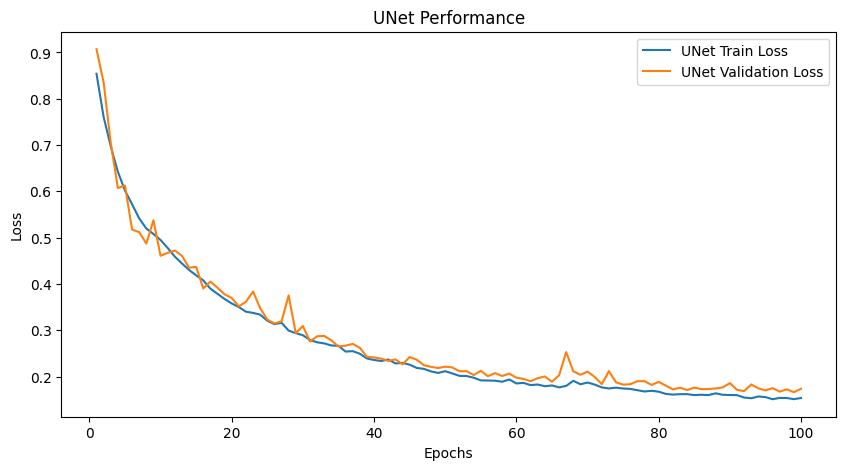

In [33]:
epochs = range(1, len(unet_train_loss) + 1)

plt.figure(figsize=(10, 5))

plt.plot(epochs, unet_train_loss, label='UNet Train Loss')
plt.plot(epochs, unet_val_loss, label='UNet Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('UNet Performance')
plt.legend()

plt.show()

We can see that the model succeed to decrease the loss value from around 0.9 to around 0.1. We also see that the distance between the train loss and validation loss is not high. Hence, we conclude that it is neither overfit nor underfit.

## FCN8s Performance

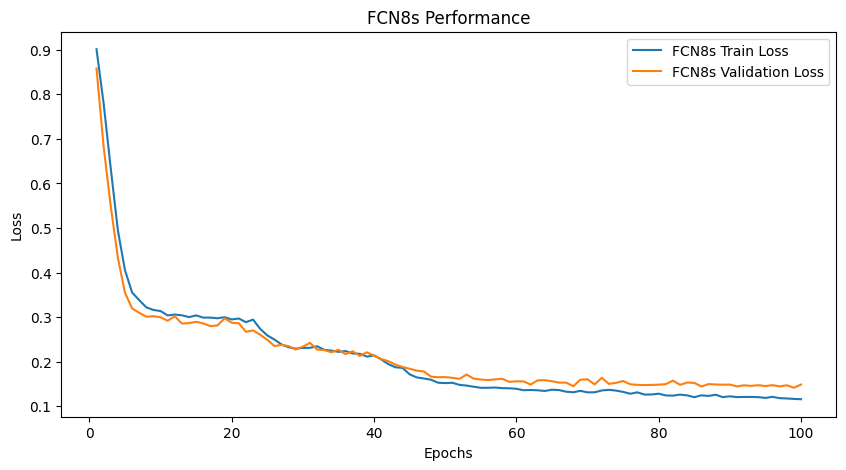

In [34]:
epochs = range(1, len(fcn_train_loss) + 1)

plt.figure(figsize=(10, 5))

plt.plot(epochs, fcn_train_loss, label='FCN8s Train Loss')
plt.plot(epochs, fcn_val_loss, label='FCN8s Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('FCN8s Performance')
plt.legend()

plt.show()

Similarly, we can see that the model succeed to decrease the loss value from around 0.9 to around 0.1. We also see that the distance between the train loss and validation loss is not high. Hence, we conclude that it is neither overfit nor underfit.

## Loss Comparison

Next, we will compare both model's losses value including the test loss. We compute the test loss using the following function.

In [35]:
def test_engine(dataloader, model, loss_fn):
    model.eval()
    loss_one_step = 0
    loop = tqdm(dataloader)

    for data, targets in loop:
        data = data.to('cuda')
        targets = targets.float().to(device="cuda")
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                predictions = model(data)
                loss = loss_fn(targets, predictions)
        loss_one_step += loss.item()

        loop.set_postfix(loss=loss.item())

    return loss_one_step / len(dataloader)

unet_test_loss = test_engine(test_dataloader, unet, dice_loss)
fcn_test_loss = test_engine(test_dataloader, fcn, dice_loss)

100%|██████████| 4/4 [00:01<00:00,  2.27it/s, loss=0.178]


In [36]:
loss_df = pd.DataFrame({'Model':['UNet', 'FCN8s'],
                        'Train Loss':[unet_train_loss[-1], fcn_train_loss[-1]],
                        'Validation Loss':[unet_val_loss[-1], fcn_val_loss[-1]],
                        'Test Loss':[unet_test_loss, fcn_test_loss]})

loss_df

,Model,Train Loss,Validation Loss,Test Loss
0,UNet,0.153932,0.173742,0.223557
1,FCN8s,0.115978,0.148911,0.161057


We attain that in the train and validation dataset, the loss of UNet is better than the loss of FCN8s. However, the test loss give different interpretation in which the FCN8s is slightly better.

## Dice Coefficient Comparison

Next, we will compare both model using dice coefficient. We construct the dice coefficient function as follows to compute the score of each classes.

In [37]:
def calculate_dice_coefficient_per_class(ground_truth, predicted, num_classes):
    dice_scores = []
    for c in range(num_classes):
        # Extract the class mask for ground truth and predictions
        gt_class = (ground_truth == c).float()
        pred_class = (predicted == c).float()

        # Calculate intersection and union
        intersection = (gt_class * pred_class).sum()
        dice_score = (2.0 * intersection) / (gt_class.sum() + pred_class.sum() + 1e-5)
        dice_scores.append(dice_score.item())
    return dice_scores

def calculate_average_dice_coefficient(ground_truths, predictions, num_classes):
    num_samples = len(ground_truths)
    dice_coefficients = np.zeros((num_samples, num_classes))
    for i in range(num_samples):
        dice_coefficients[i] = calculate_dice_coefficient_per_class(ground_truths[i], predictions[i], num_classes)
    return dice_coefficients.mean(axis=0)  # Per-class average

def dice_coeff_engine(dataloader, model, num_classes):
    model.eval()
    scores = []
    loop = tqdm(dataloader)

    for data, targets in loop:
        data = data.to('cuda')
        targets = targets.long().to('cuda')
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                predictions = model(data)
                # Get the predicted class for each pixel
                predicted_classes = predictions.argmax(dim=1)
                score = calculate_average_dice_coefficient(targets, predicted_classes, num_classes)
        scores.append(score)
        loop.set_postfix(mean_dice=np.mean(score))

    # Average across all batches and return per-class dice scores
    mean_dice_per_class = np.mean(scores, axis=0)
    return mean_dice_per_class, mean_dice_per_class.mean()

num_classes = 12
unet_train_score, unet_train_mean_dice = dice_coeff_engine(train_dataloader, unet, num_classes)
unet_val_score, unet_val_mean_dice = dice_coeff_engine(val_dataloader, unet, num_classes)
unet_test_score, unet_test_mean_dice = dice_coeff_engine(test_dataloader, unet, num_classes)

fcn_train_score, fcn_train_mean_dice = dice_coeff_engine(train_dataloader, fcn, num_classes)
fcn_val_score, fcn_val_mean_dice = dice_coeff_engine(val_dataloader, fcn, num_classes)
fcn_test_score, fcn_test_mean_dice = dice_coeff_engine(test_dataloader, fcn, num_classes)

100%|██████████| 4/4 [00:03<00:00,  1.16it/s, mean_dice=0.0459]


In [38]:
print('------ Dice Coeeficient of UNet in Train Dataset ------')
for i in range(12):
  print(f'Class {i}: {unet_train_score[i]}')

print('------ Dice Coeeficient of UNet in Validation Dataset ------')
for i in range(12):
  print(f'Class {i}: {unet_val_score[i]}')

print('------ Dice Coeeficient of UNet in Test Dataset ------')
for i in range(12):
  print(f'Class {i}: {unet_test_score[i]}')

print('------ Dice Coeeficient of FCN in Train Dataset ------')
for i in range(12):
  print(f'Class {i}: {fcn_train_score[i]}')

print('------ Dice Coeeficient of FCN in Validation Dataset ------')
for i in range(12):
  print(f'Class {i}: {fcn_val_score[i]}')

print('------ Dice Coeeficient of FCN in Test Dataset ------')
for i in range(12):
  print(f'Class {i}: {fcn_test_score[i]}')

------ Dice Coeeficient of UNet in Train Dataset ------
Class 0: 0.3442432640305344
Class 1: 0.3661005136514723
Class 2: 0.0
Class 3: 0.0
Class 4: 0.0
Class 5: 0.0
Class 6: 0.0
Class 7: 0.0
Class 8: 0.0
Class 9: 0.0
Class 10: 0.0
Class 11: 0.0
------ Dice Coeeficient of UNet in Validation Dataset ------
Class 0: 0.3429628120618872
Class 1: 0.3985552912893278
Class 2: 0.0
Class 3: 0.0
Class 4: 0.0
Class 5: 0.0
Class 6: 0.0
Class 7: 0.0
Class 8: 0.0
Class 9: 0.0
Class 10: 0.0
Class 11: 0.0
------ Dice Coeeficient of UNet in Test Dataset ------
Class 0: 0.1889535052701831
Class 1: 0.4104885561391711
Class 2: 0.0
Class 3: 0.0
Class 4: 0.0
Class 5: 0.0
Class 6: 0.0
Class 7: 0.0
Class 8: 0.0
Class 9: 0.0
Class 10: 0.0
Class 11: 0.0
------ Dice Coeeficient of FCN in Train Dataset ------
Class 0: 0.35220902600114184
Class 1: 0.36713980719776373
Class 2: 0.0
Class 3: 0.0
Class 4: 0.0
Class 5: 0.0
Class 6: 0.0
Class 7: 0.0
Class 8: 0.0
Class 9: 0.0
Class 10: 0.0
Class 11: 0.0
------ Dice Coeefic

We see that only class 0 and 1 that has dice coefficient. This is probably because the number of class 0 and class 1 are significantly higher than other classes. Next, we use the mean of these scores to compare both model.

In [39]:
score_df = pd.DataFrame({'Model':['UNet', 'FCN8s'],
                        'Train Score':[unet_train_mean_dice, fcn_train_mean_dice],
                        'Validation Score':[unet_val_mean_dice, fcn_val_mean_dice],
                        'Test Score':[unet_test_mean_dice, fcn_test_mean_dice]})

score_df

,Model,Train Score,Validation Score,Test Score
0,UNet,0.059195,0.061793,0.049954
1,FCN8s,0.059946,0.061847,0.049611


The dice coefficient score in each datasets of FCN8s are slightly higher than those in the UNet. This indicates that FCN8s is better than UNet in this study case.

# Model Visualization

Now, we will try to visualize both model over the test dataset. We create the following function to support our goal.

In [55]:
def inference(tensor, model):
    with torch.no_grad():
        tensor = torch.unsqueeze(tensor, dim=0).to('cuda')
        result = model(tensor)
        result = torch.softmax(result, dim=1)
    return result

def imshow_from_tensor(tensor):
    # Get the class with the highest probability for each pixel
    tensor = torch.argmax(tensor, dim=0).cpu().detach().numpy()
    return tensor

## UNet Visualization

We apply those functions to visualize the resul of UNet as follows.

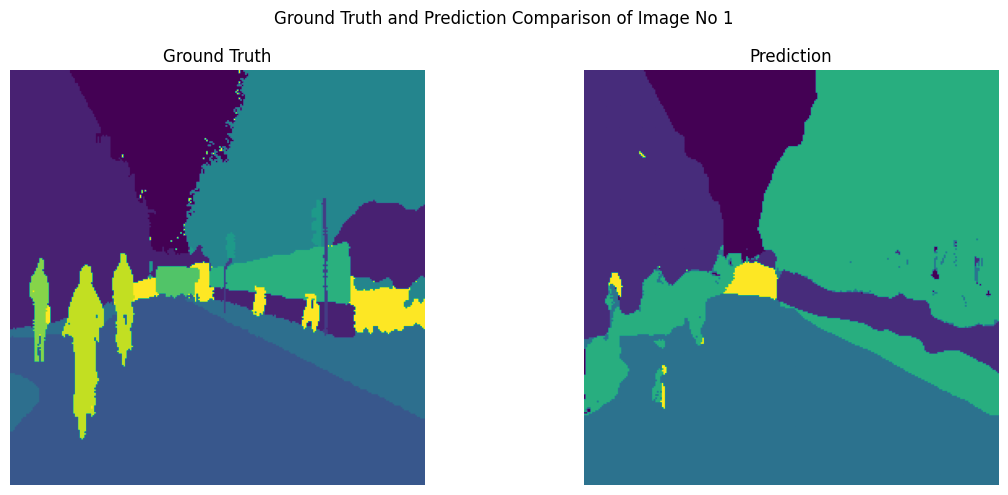

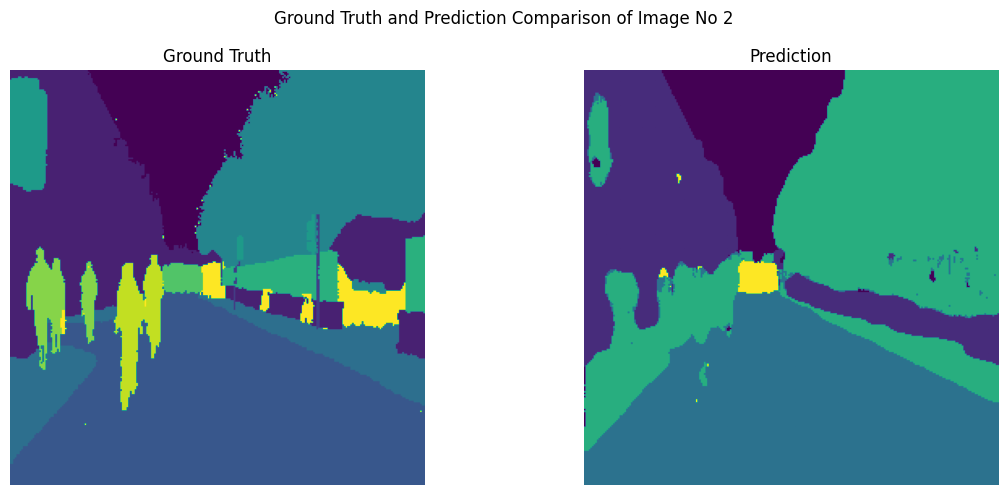

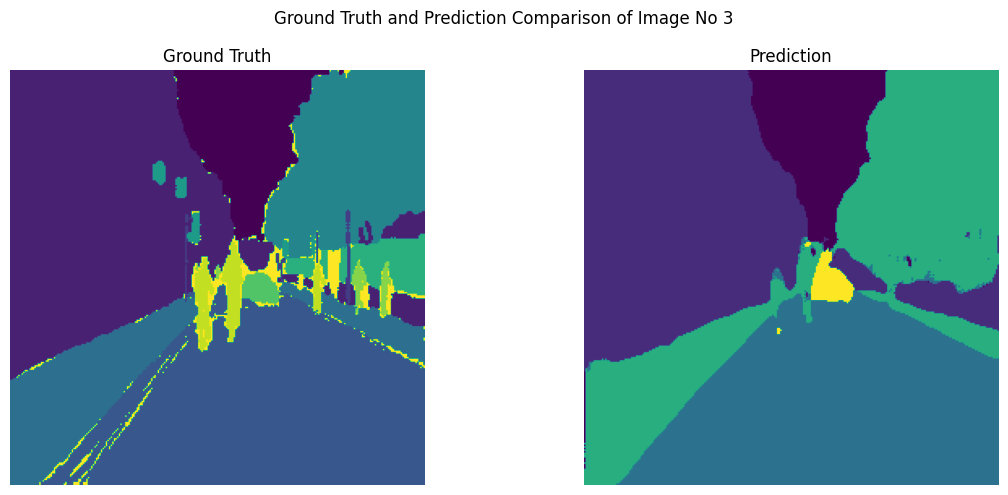

In [56]:
get = 3

for i in range(get):
    data, targets = test_datasets[i]
    result = inference(data, unet)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    image_ori = imshow_from_tensor(targets)
    plt.imshow(image_ori)
    plt.axis('off')
    plt.title('Ground Truth')

    plt.subplot(1, 2, 2)
    image = imshow_from_tensor(result[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('Prediction')

    plt.suptitle(f'Ground Truth and Prediction Comparison of Image No {i+1}')
    plt.tight_layout()
    plt.show()

## FCN8s Visualization

Likewise, we also use both function to visualize the result of FCN8s.

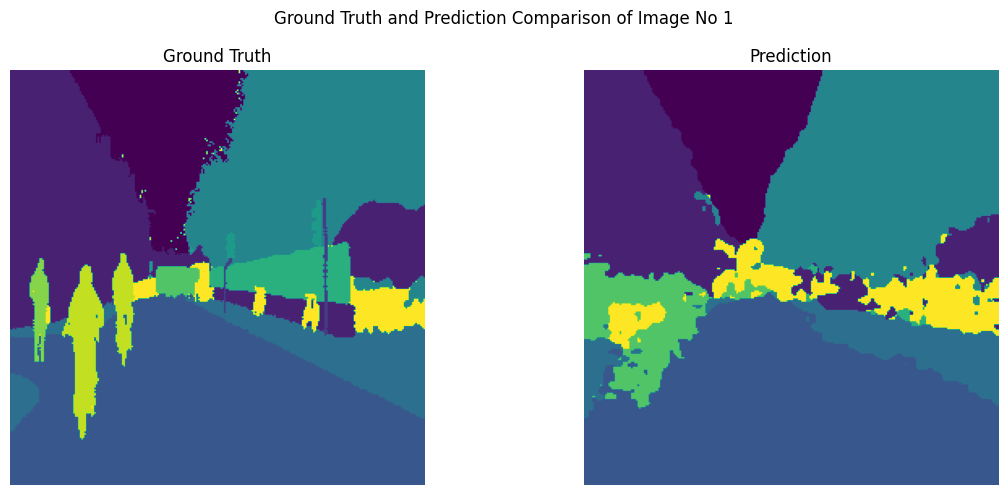

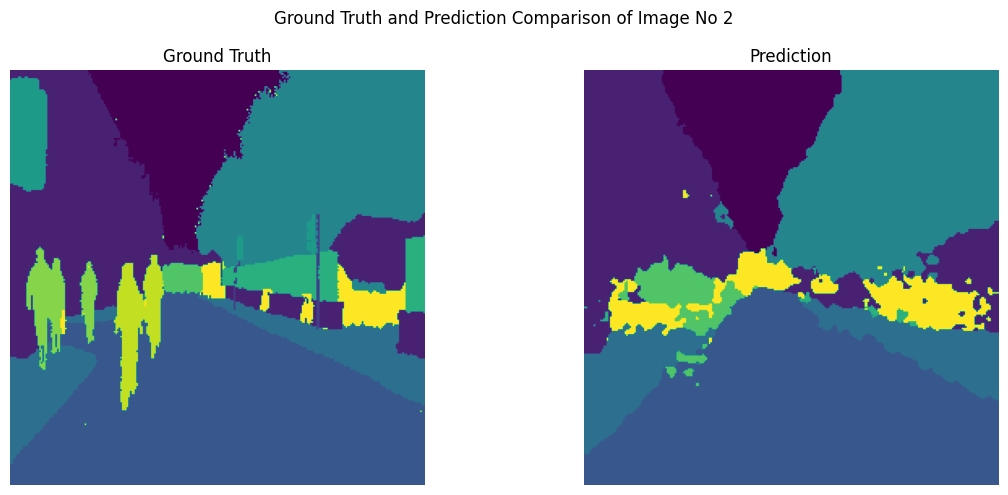

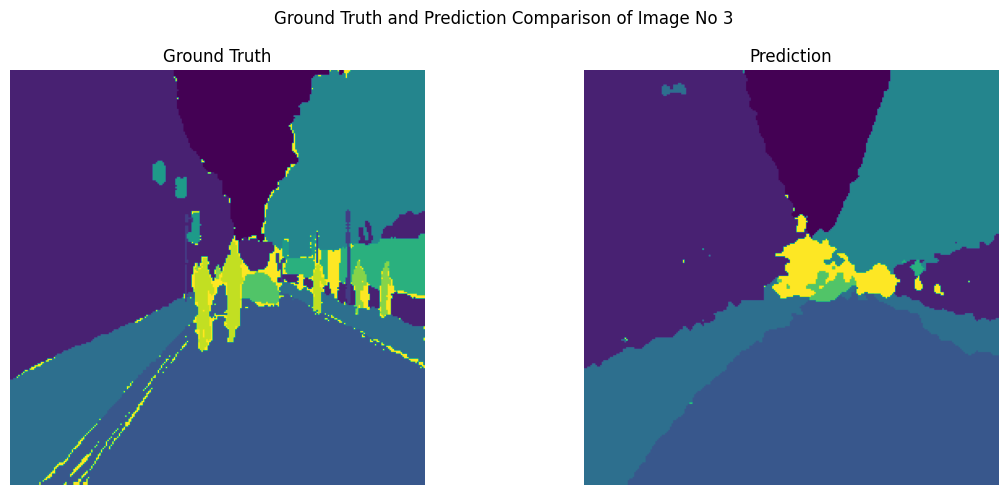

In [57]:
get = 3

for i in range(get):
    data, targets = test_datasets[i]
    result = inference(data, fcn)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    image_ori = imshow_from_tensor(targets)
    plt.imshow(image_ori)
    plt.axis('off')
    plt.title('Ground Truth')

    plt.subplot(1, 2, 2)
    image = imshow_from_tensor(result[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('Prediction')

    plt.suptitle(f'Ground Truth and Prediction Comparison of Image No {i+1}')
    plt.tight_layout()
    plt.show()

If we compare both visualization, we can see that the UNet has better visualization since the objects are formed well. Meanwhile the object visualization of FCN8s is remains abstract and cannot easily understood.

# Conclusion

In conclusion, the FCN8s has better performance than UNet based on the loss value and dice coefficient value. However, the visualization of  UNet is better than FCN8s. This indicates that FCN8s is better in distinguishing the objects but it is worse in creating the mask. If we see the loss and dice coefficient value again, we see that the difference between both model is small which illustrates that UNet is not too bad. Therefore, if our goal focuses on distingushing the objects, then FCN8s is the best to be implemented, but if our goal focuses on masking the object regardless what the object is, then UNet is the best to be implemented.